# Introduction

This notebook demonstrates how tomography is used in accelerator physics to reconstruct longitudinal phase space of a bunch.

27.09.2022, Adrian Oeftiger

## Wall Current Monitor

In the vacuum tube, the <span style='color:#0C0;'>Beam</span> traverses a tube gap with <span style='color:red;'>resistors</span>, the <span style='color:#CC0;'>induced mirror current</span> builds up voltage:

$$ V_{gap} = R_{gap} \cdot I_{beam}$$

<img src="img/wcm.png" alt="wall current monitor principle" style="width:50%;margin:auto;margin-top:1em;" />

<p style="font-size: small; text-align: right;">image source: <a href="https://uspas.fnal.gov/materials/09UNM/BeamCurrentMonitors.pdf">USPAS09</a> (W. Blokland, U. Raich)</p>

## Beam Measurements

Consider a circulating bunch in a synchrotron or storage ring. Longitudinal bunch profiles can be recorded via wall current monitor with a high-bandwidth oscilloscope: store $V_{gap}(t)$ during the bunch passage time $t$.

# Let's get started!

## Imports

In [1]:
from talksetup import *

import longitudinal_tomography.tomography.tomography as tmo
from longitudinal_tomography.tracking import particles, machine

import longitudinal_tomography.utils.tomo_input as tomoin
import longitudinal_tomography.utils.tomo_output as tomoout
from longitudinal_tomography.tracking import tracking

In [2]:
from PyHEADTAIL.particles.generators import RFBucketMatcher, ThermalDistribution
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.16.0




In [3]:
from scipy.constants import m_p, e, c

## Physical beam parameters

During previous lectures we discussed reduced models for the longitudinal plane. We have 

- `voltage`: rf voltage
- `harmonic`: rf frequency divided by revolution frequency
- `circumference`: accelerator ring circumference
- `gamma`: Lorentz gamma of bunch
- `alpha_c`: momentum compaction of the ring

In [4]:
voltage = 24e3
harmonic = 8
circumference = 100 * 2 * np.pi

gamma = 2.5
beta = np.sqrt(1 - gamma**-2)

alpha_c = 0.027
eta = alpha_c - gamma**-2

We look at a circulating proton bunch in a CERN Proton Synchrotron like machine. A full bunch length of 80ns translates to the rms bunch length `sigma_z`. The following `RFBucket` class captures most of the important quantities for computation.

In [5]:
rfb = RFBucket(circumference, gamma, m_p, e, [alpha_c], 0., [harmonic], [voltage], [np.pi])

sigma_z = 80e-9 * beta * c / 4. # in [m]

# A. The simulations

## Initialisation of particles

A thermal distribution (Gaussian-like) of particles is matched into the rf bucket.

In [6]:
rfb_matcher = RFBucketMatcher(rfb, ThermalDistribution, sigma_z=sigma_z)
rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 12.378373605203068m.
... distance to target bunch length: -5.4650e+00
... distance to target bunch length: 6.5416e+00
... distance to target bunch length: 5.0576e+00
... distance to target bunch length: 8.1334e-01
... distance to target bunch length: -2.6179e-01
... distance to target bunch length: -4.3733e-03
... distance to target bunch length: 7.3369e-06
... distance to target bunch length: -2.3468e-05
--> Bunch length: 5.4952938631392385
--> Emittance: 0.27882345475015563


The distribution in longitudinal phase space $(z, \delta)$ looks as follows:

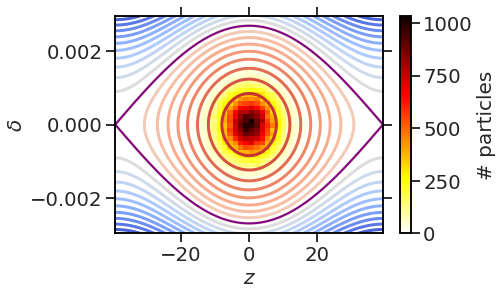

In [7]:
plot_mp(z, dp, rfb);

Let's have a look at the bunch profile as it would appear in a discrete measurement (e.g. via a wall current monitor):

In [8]:
nbins = 100
z_bins = np.linspace(*rfb.interval, num=nbins-1)

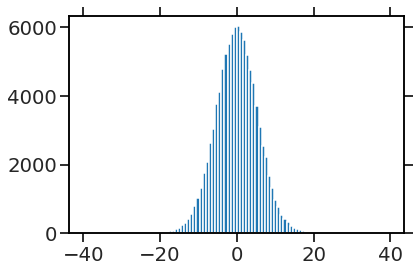

In [9]:
plt.hist(z, bins=z_bins);

A single bin of the profile measurement amounts to a time (in seconds) of 

In [10]:
dtbin = (z_bins[1] - z_bins[0]) / (beta * c)
dtbin

2.9459463503917286e-09

The synchrotron period `T_s`, i.e. the time period of the longitudinal motion, amounts to the following number of turns:

In [11]:
T_s = int(1 / rfb.Q_s)
T_s

696

## Deliberate mismatch

To provide some interesting dynamics for the tomographic reconstruction, let's mismatch the distribution in momentum. This will launch a quadrupolar oscillation, i.e. the beam size and momentum spread will oscillate during the synchrotron period.

In [12]:
dp *= 0.8

As one can see, the distribution does not follow the iso-Hamiltonian lines (red) any longer but is slightly compressed along the momentum $\delta$ axis:

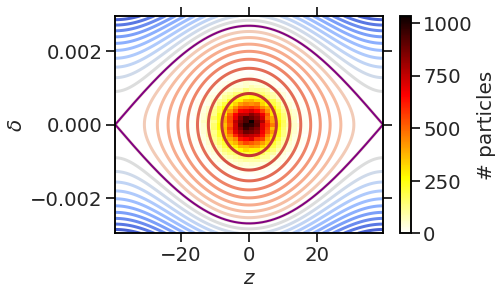

In [13]:
plot_mp(z, dp, rfb);

## Particle tracking

We model the synchrotron motion of the particles due to the rf cavities via a leap-frog integrator. The `track` function advances the particles by one turn:

In [14]:
def track(z, dp):
    # half drift
    z = z - eta * dp * circumference / 2
    # rf kick
    amplitude = rfb.charge * voltage / (beta * c * rfb.p0)
    phi = harmonic * (2 * np.pi * z / circumference) + rfb.phi_offset_list[0]
    dp += amplitude * np.sin(phi)
    # half drift
    z = z - eta * dp * circumference / 2
    return z, dp

Let's gather the data for the tomographic reconstruction by recording a bunch profile every few turns during one `T_s`:

In [15]:
record_every_nturns = 10

In [16]:
raw_data = [np.histogram(z, bins=z_bins)[0]]

for i in tqdm(range(1, 700 + 1)):
    z, dp = track(z, dp)
    if not i % record_every_nturns:
        raw_data += [np.histogram(z, bins=z_bins)[0]]

  0%|          | 0/700 [00:00<?, ?it/s]

The quadrupole oscillation is clearly visible:

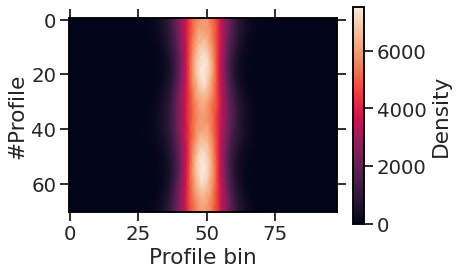

In [17]:
plt.imshow(raw_data)
plt.xlabel('Profile bin')
plt.ylabel('#Profile')
plt.colorbar(label='Density');

$\implies$ Can you explain why one expects the shortest bunch length (the density peak) after a quarter of the synchrotron period?

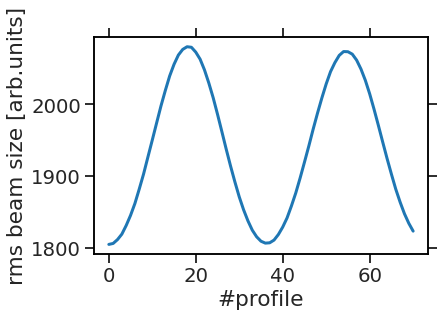

In [18]:
plt.plot(np.std(raw_data, axis=1))
plt.xlabel('#profile')
plt.ylabel('rms beam size [arb.units]');

# B. The longitudinal tomography

## Preparations

The `longitudinal_tomography` package from CERN requires a certain input format for the parameters (voltage, frequency, etc):

In [19]:
frame_input_args = {
    'raw_data_path':    './',
    'framecount':       len(raw_data), # Number of frames in input data
    'skip_frames':      0, # Number of frames to ignore
    'framelength':      len(raw_data[0]), # Number of bins in each frame
    'dtbin':            dtbin, # Width (in s) of each frame bin
    'skip_bins_start':  0, # Number of frame bins before the lower profile bound to ignore
    'skip_bins_end':    0, # Number of frame bins after the upper profile bound to ignore
    'rebin':            1, #Number of frame bins to rebin into one profile bin
}

In [20]:
machine_args = {
    'output_dir':           '/tmp/', # Directory in which to write all output
    'dtbin':                dtbin, # Width (in s) of each frame bin
    'dturns':               record_every_nturns, # Number of machine turns between frames
    'synch_part_x':         frame_input_args['framelength']/2, # Time (in frame bins) from the lower profile bound to the synchronous phase (if <0, a fit is performed) in the "bunch reference" frame
    'demax':                -1e6, # noqa - Max energy (in eV) of reconstructed phase space (if >0)
    'filmstart':            0, # Number of the first profile at which to reconstruct
    'filmstop':             1, # Number of the last profile at which to reconstruct
    'filmstep':             1, # Step between reconstructions
    'niter':                20, # Number of iterations for each reconstruction
    'snpt':                 4, # Square root of the number of test particles to track per cell
    'full_pp_flag':         False, # Flag to extend the region in phase space of map elements (if =1)
    'beam_ref_frame':       0, # Reference frame for bunch parameters (synchronous phase, baseline, integral)
    'machine_ref_frame':    0, # Reference frame for machine parameters (RF voltages, B-field)
    'vrf1':                 voltage, # Peak RF voltage (in V) of principal RF system
    'vrf1dot':              0.0, # and its time derivative (in V/s)
    'vrf2':                 0.0, # Peak RF voltage (in V) of higher-harmonic RF system
    'vrf2dot':              0.0, # and its time derivative (in V/s)
    'h_num':                harmonic, # Harmonic number of principal RF system
    'h_ratio':              2.0, # Ratio of harmonics between RF systems
    'phi12':                0, # Phase difference (in radians of the principal harmonic) between RF systems
    'b0':                   0.1, # Dipole magnetic field (in T) -- up to 1.8T
    'bdot':                 0.0, # and its time derivative (in T/s) -- up to 10T/s
    'mean_orbit_rad':       circumference / (2 * np.pi), # Machine radius (in m)
    'bending_rad':          70.08, # Bending radius (in m)
    'trans_gamma':          alpha_c**-0.5, # Gamma transition
    'rest_energy':          m_p * c**2 / e, # Rest mass (in eV/c**2) of accelerated particle
    'charge':               1, # Charge state of accelerated particle
    'self_field_flag':      False, # Flag to include self-fields in the tracking (if =1)
    'g_coupling':           0.0, # Geometrical coupling coefficient
    'zwall_over_n':         0.0, # Reactive impedance (in Ohms per mode number) over a machine turn
    'pickup_sensitivity':   1, # Effective pick-up sensitivity (in digitizer units per instantaneous Amp)
    'nprofiles':            frame_input_args['framecount'],
    'nbins':                frame_input_args['framelength'],
    'min_dt':               0.0,
    'max_dt':               dtbin * frame_input_args['framelength'],
}


In [21]:
frames = tomoin.Frames(**frame_input_args)

mach = machine.Machine(**machine_args)

mach.values_at_turns()

The tomography package uses the waterfall plot as measured sinogram input then:

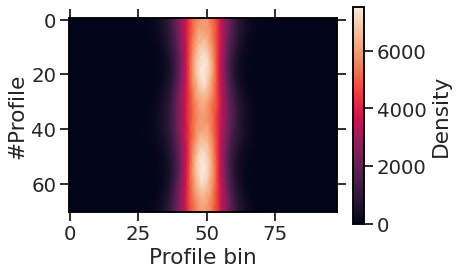

In [22]:
measured_waterfall = frames.to_waterfall(np.array(raw_data, dtype=float).flatten())

plt.imshow(measured_waterfall)
plt.xlabel('Profile bin')
plt.ylabel('#Profile')
plt.colorbar(label='Density');

In [23]:
profiles = tomoin.raw_data_to_profiles(
    measured_waterfall, mach, frames.rebin, frames.sampling_time)
profiles.calc_profilecharge()

In [24]:
if profiles.machine.synch_part_x < 0:
    fit_info = dtreat.fit_synch_part_x(profiles)
    mach.load_fitted_synch_part_x_ftn(fit_info)

Reconstruction will be at the following index (e.g. the start):

In [25]:
reconstr_idx = mach.filmstart

Establishing the map (nonlinear synchrotron motion):

In [26]:
tracker = tracking.Tracking(mach)

In [27]:
xp, yp = tracker.track(reconstr_idx)

In [28]:
# Converting from physical coordinates ([rad], [eV])
# to phase space coordinates.
if not tracker.self_field_flag:
    xp, yp = particles.physical_to_coords(
        xp, yp, mach, tracker.particles.xorigin,
        tracker.particles.dEbin)


In [29]:
xp, yp = particles.ready_for_tomography(xp, yp, mach.nbins)

In [30]:
waterfall = profiles.waterfall

## Tomographic reconstruction

In [31]:
# Reconstructing phase space
tomo = tmo.TomographyCpp(waterfall, xp)
weight = tomo.run(niter=mach.niter)

In [32]:
image = tomoout.create_phase_space_image(
    xp, yp, weight, nbins, reconstr_idx)

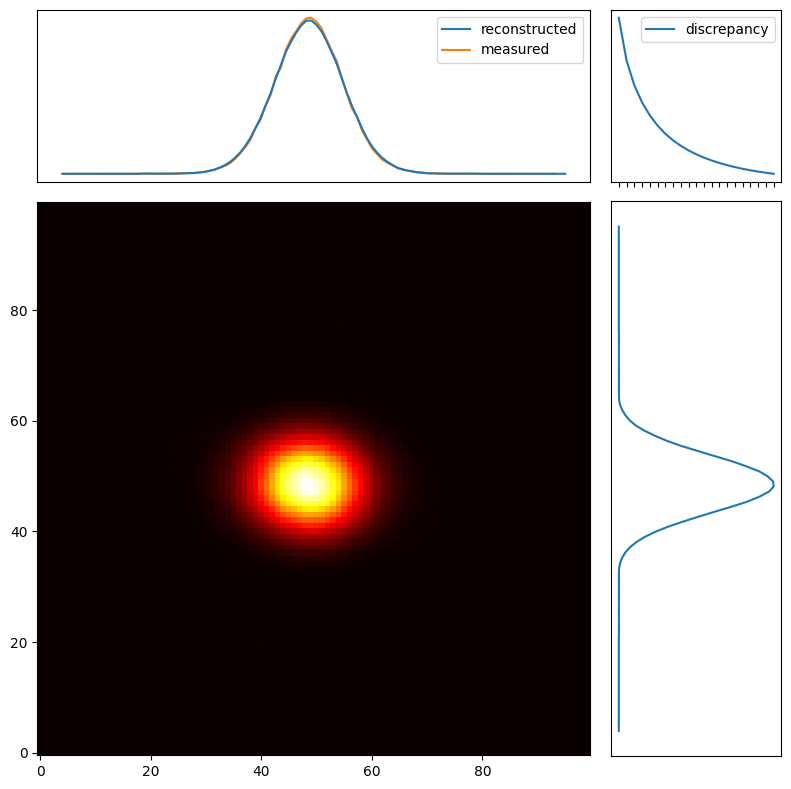

In [33]:
matplotlib.rc_file_defaults()

tomoout.show(image, tomo.diff, waterfall[reconstr_idx])

$\implies$ The reconstruction fits the tracked data exactly!

What happens if you increase the bunch length (total of 140ns instead of 80ns?)?

Can you see the non-linearities if you simulate a bunch rotation (significantly smaller momentum spread $\delta$ than the matched figure, e.g. 10%)?

What happens here if you add noise to the measurements in the sinogram?

.

.

.

.

## Step-by-step version

Same reproduction again but with intermediate steps:

In [34]:
niterations = 50
nprofs = waterfall.shape[0]
nbins = waterfall.shape[1]
nparts = xp.shape[0]
rec_tframe = 0

In [35]:
flat_profs = waterfall.copy()
flat_profs = flat_profs.clip(0.0)

In [36]:
flat_profs /= np.sum(flat_profs, axis=1)[:, None]
flat_profs = np.ascontiguousarray(flat_profs.flatten()).astype(float)

In [37]:
waterfall /= np.sum(waterfall, axis=1)[:, None]

In [38]:
flat_points = xp.copy()
for i in range(nprofs):
    flat_points[:, i] += nbins * i

Starting the algebraic reconstruction technique (ART) algorithm:

In [39]:
# Reconstructing phase space
weight = np.zeros(nparts)
rec_wf = np.zeros(waterfall.shape)

In [40]:
# Initial estimation of weight factors using (flattened) measured profiles.
weight = tmo.libtomo.back_project(weight, flat_points, flat_profs,
                                  nparts, nprofs)
weight = weight.clip(0.0)

In [41]:
diff = []
for i in range(niterations):
    # Projection from phase space to time projections
    rec_wf = tmo.libtomo.project(rec_wf, flat_points, weight, nparts,
                                 nprofs, nbins)

    # Normalizing reconstructed waterfall
    rec_wf /= np.sum(rec_wf, axis=1)[:, None]

    # Finding difference between measured and reconstructed waterfall
    dwaterfall = waterfall - rec_wf

    # Setting to zero for next round
    rec_wf[:] = 0.0

    # Calculating discrepancy
    diff.append(np.sqrt(np.sum(dwaterfall ** 2) / (nbins * nprofs)))

    # Back projecting using the difference between measured and rec. waterfall
    weight = tmo.libtomo.back_project(weight, flat_points, dwaterfall.flatten(),
                                      nparts, nprofs)
    weight = weight.clip(0.0)

    print(f'Iteration: {i:3d}, discrepancy: {diff[-1]:3e}')

Iteration:   0, discrepancy: 1.202094e-02
Iteration:   1, discrepancy: 9.937578e-03
Iteration:   2, discrepancy: 8.501094e-03
Iteration:   3, discrepancy: 7.440103e-03
Iteration:   4, discrepancy: 6.647480e-03
Iteration:   5, discrepancy: 6.014205e-03
Iteration:   6, discrepancy: 5.488721e-03
Iteration:   7, discrepancy: 5.042137e-03
Iteration:   8, discrepancy: 4.656293e-03
Iteration:   9, discrepancy: 4.318305e-03
Iteration:  10, discrepancy: 4.019213e-03
Iteration:  11, discrepancy: 3.752396e-03
Iteration:  12, discrepancy: 3.512569e-03
Iteration:  13, discrepancy: 3.295639e-03
Iteration:  14, discrepancy: 3.098520e-03
Iteration:  15, discrepancy: 2.918682e-03
Iteration:  16, discrepancy: 2.754045e-03
Iteration:  17, discrepancy: 2.602845e-03
Iteration:  18, discrepancy: 2.463648e-03
Iteration:  19, discrepancy: 2.335283e-03
Iteration:  20, discrepancy: 2.216555e-03
Iteration:  21, discrepancy: 2.106453e-03
Iteration:  22, discrepancy: 2.004201e-03
Iteration:  23, discrepancy: 1.909

In [42]:
# Finding last discrepancy...
rec_wf = tmo.libtomo.project(rec_wf, flat_points, weight, nparts, nprofs, nbins)
rec_wf /= np.sum(rec_wf, axis=1)[:, None]
dwaterfall = waterfall - rec_wf
diff.append(np.sqrt(np.sum(dwaterfall ** 2) / (nbins * nprofs)))
print(f'Iteration: {i + 1:3d}, discrepancy: {diff[-1]:3E}')

Iteration:  50, discrepancy: 7.085775E-04


Reconstruction finished, showing the phase-space image:

In [43]:
image = tomoout.create_phase_space_image(
    xp, yp, weight, nbins, rec_tframe)

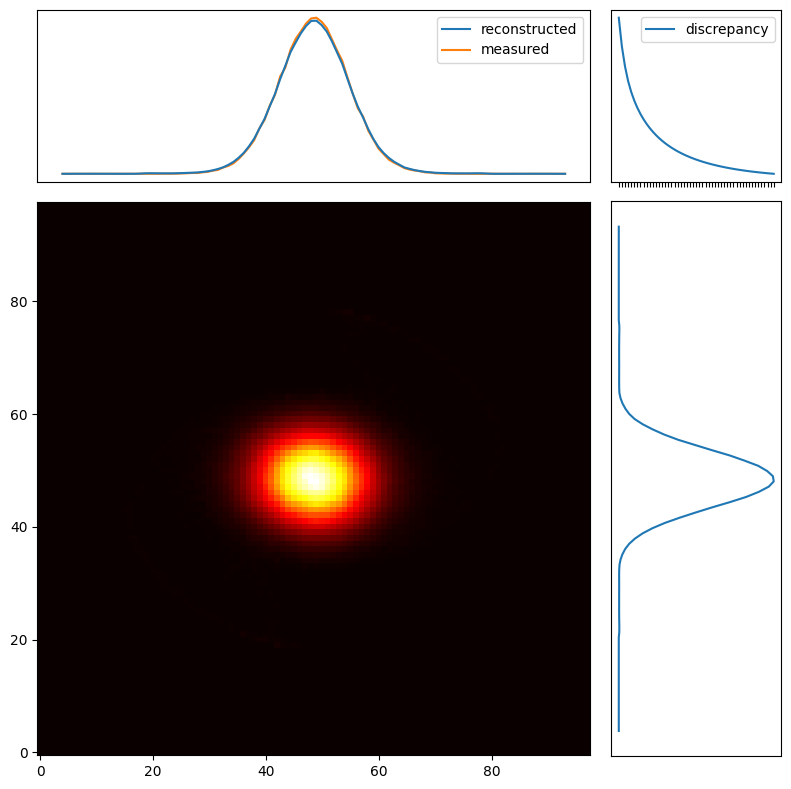

In [44]:
tomoout.show(image, diff, waterfall[rec_tframe])